# Catalog AI

This notebook implements a toy version of the **Catalog AI** system discussed in [Addressing Gen AI's Quality Control Problem](https://hbr.org/2025/09/addressing-gen-ais-quality-control-problem) (Harvard Business Review)

![Harvard Business Review article header showing title Addressing Gen AI's Quality Control Problem](../01-online-retail-simulator/article.png)

Generative AI systems can produce vast numbers of candidate product data improvements, but at scale the central problem is not generation—it is quality control and learning. When Amazon began automating product data improvements using large language models to enhance product `title`, `description`, and `features`, most generated outputs were initially unreliable, and only a small fraction improved business outcomes like conversion and revenue. The solution was not human review, but a self-learning system that combines automated guardrails to filter low-quality outputs, experimentation to measure impact on shopper behavior, and feedback loops that use experimental results to guide future generation. The system can test millions of product data hypotheses, discard most of them, and continuously learn from the few that work. This notebook introduces a simplified, toy version of that idea: how to build a **Learn · Decide · Repeat** loop that turns large-scale product data analysis into action and learning over time.

![Online Retail Simulator architecture diagram showing the Learn Decide Repeat workflow](../01-online-retail-simulator/online-retail-simulator.png)

We use the **[Online Retail Simulator](https://github.com/eisenhauerIO/tools-catalog-generator)** to demonstrate three capabilities. First, we generate product `title`, `description`, and `features` using a local LLM via [**Ollama**](https://ollama.com/) with customizable prompts. Using simulated data, we then apply causal impact measurement to establish whether these content improvements actually drive shopper behavior and sales, and to identify which positioning strategy—luxury versus budget—produces the strongest business outcomes. This illustrates how impact measurement guides data-driven content strategy selection.

Before running this notebook, execute the setup script `setup_catalog_ai.sh` to install and configure Ollama:

```bash
bash setup_catalog_ai.sh
```

The script installs the Online Retail Simulator package and sets up Ollama with the `llama3.2` model.

In [ ]:
# Standard library
import inspect
from operator import itemgetter

# Third-party packages
from IPython.display import Code

# Local imports
from online_retail_simulator import simulate, load_job_results, enrich
from online_retail_simulator.simulate.product_details_ollama import simulate_product_details_ollama
from support import (
    print_product_details,
    plot_treatment_effect,
    plot_positioning_comparison,
    print_positioning_comparison,
)

NUM_SAMPLE_PRODUCTS = 2

## Generate Product Content with Ollama

The [**Ollama**](https://ollama.com/) backend uses a local LLM to generate unique, contextually-aware product `title`, `description`, and `features`. Custom prompts let you control the tone and style—enabling different **positioning strategies** for the same products. We'll start by generating product content using a value-focused positioning strategy that emphasizes practicality and affordability.

### Generate Baseline Product Content


We start by generating a product catalog with basic **characteristics** using the simulator. These base products contain `product_identifier`, `category`, and `price`—the foundation upon which we'll generate detailed product content.

In [ ]:
# Start with base products before adding AI-generated content
job_info = simulate("config_simulation.yaml")
products, metrics = itemgetter("products", "metrics")(load_job_results(job_info))

In [ ]:
# Select sample products for demonstration
sample_products = products[["product_identifier", "category", "price"]].head(NUM_SAMPLE_PRODUCTS)
sample_products

### Generate Product Content with AI

We'll use a value-focused prompt template that guides the LLM to generate practical, budget-friendly product content. The prompt emphasizes functionality, value, and affordability.

In [ ]:
# Display the budget positioning prompt template
! cat "prompt_budget.txt"

In [ ]:
# Generate budget-positioned product content using Ollama LLM
budget_products = simulate_product_details_ollama(sample_products, prompt_path="prompt_budget.txt")
print_product_details(budget_products, "Budget")

To understand how the generation works under the hood, let's examine the `simulate_product_details_ollama()` function. It batches products, formats them as JSON, injects them into the prompt template, and sends requests to the local Ollama API.

In [ ]:
Code(inspect.getsource(simulate_product_details_ollama), language="python")

## Measure Impact on Sales

Generating content is only the first step. To build a self-learning system, we need to measure whether improved product content actually drives shopper behavior and business outcomes. Using the simulator's enrichment capability, we can inject known treatment effects and validate our measurement approach against ground truth.

The simulator lets us inject known treatment effects through the **enrichment** layer. We specify the `effect_size` (percentage boost in sales), `enrichment_start` date, and which products receive treatment. This creates a controlled experiment where we know the true causal impact.

In [7]:
!cat "config_enrichment_budget.yaml"

IMPACT:
  FUNCTION: product_detail_boost
  PARAMS:
    effect_size: 0.75
    ramp_days: 0
    enrichment_fraction: 1.0
    enrichment_start: "2024-11-15"
    seed: 42
    backend: "ollama"
    prompt_path: "prompt_budget.txt"


Now we'll use the budget prompt to generate enhanced product content and simultaneously inject a 75% sales boost. This simulates what would happen if improved product content actually drove higher conversion and revenue.

In [ ]:
# Apply enrichment with budget prompt
enriched_job = enrich("config_enrichment_budget.yaml", job_info)
enriched_results = load_job_results(enriched_job)

The enriched dataset contains the same metrics as before (`impressions`, `visits`, `cart_adds`, `ordered_units`, `revenue`) but now with measurable treatment effects. Let's visualize how revenue changes before and after the enrichment date.

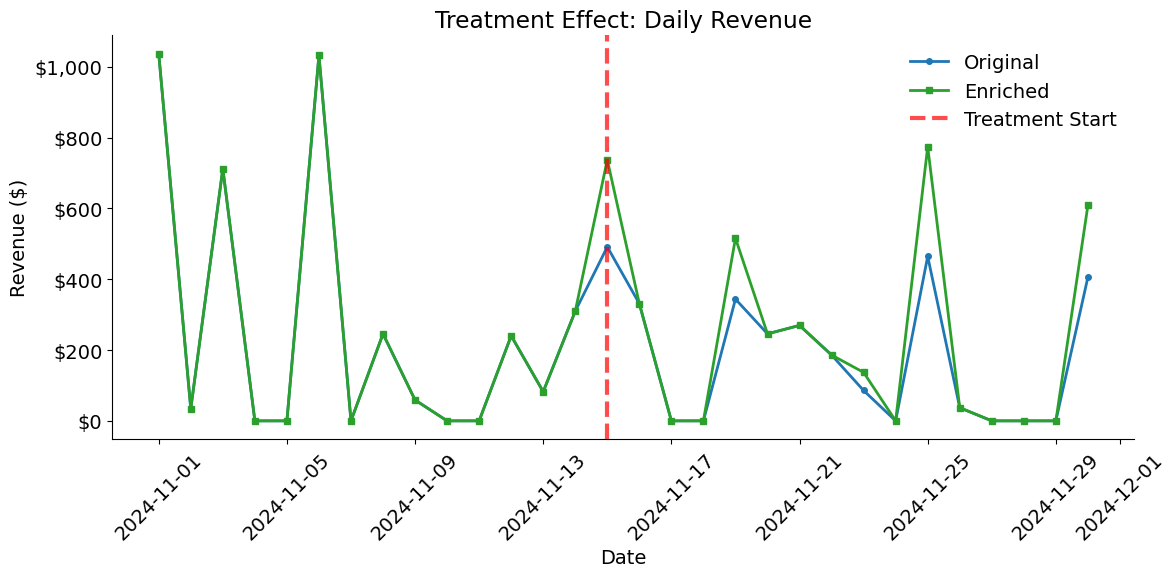

In [9]:
enriched_metrics = enriched_results["enriched"]
plot_treatment_effect(metrics, enriched_metrics, "2024-11-15")

The visualization shows clear evidence of the treatment effect—revenue increases after the enrichment date. The AI-generated product content appears to drive measurable business impact. But is this the best we can do? What if the same products were positioned differently?

## Compare Positioning Strategies

The same product can be positioned in radically different ways depending on the prompt. We've focused on value-driven, budget-friendly positioning—but what if we tried a luxury approach instead? In production systems, you'll generate thousands of content variations using different prompts, tones, and strategies. The question is: which prompt produces content that drives the strongest business impact? To answer this, we need to run parallel experiments and compare measured outcomes across positioning strategies.

Let's explore a completely different content strategy: luxury positioning. Instead of emphasizing value and practicality, luxury positioning focuses on premium quality, exclusivity, and aspirational appeal. The prompt template guides the LLM to generate elegant, sophisticated product descriptions.

In [ ]:
! cat "prompt_luxury.txt"

Let's see how the same products generate completely different content when using luxury positioning versus budget positioning. We'll apply both prompts to the same base products for comparison.

In [11]:
# Generate luxury-positioned products using the same base products
luxury_products = simulate_product_details_ollama(sample_products, prompt_path="prompt_luxury.txt")

# Display side-by-side comparison
print_product_details(budget_products, "Budget Positioning")
print("\n" + "=" * 70)
print_product_details(luxury_products, "Luxury Positioning")


BUDGET POSITIONING

  Title: Stretchy Yoga Pants for Women - Affordable Comfort
  Brand: TerraFit
  Description: Soft, breathable yoga pants perfect for women. Great for workouts, lounging around the house or as a travel companion.

  Title: Portable Power Bank - Charge On-The-Go
  Brand: EcoPower
  Description: A compact, reliable power bank for your phone or tablet. Perfect for travel, camping or daily commutes.


LUXURY POSITIONING

  Title: Velvet-Cut Velvet Blazer in Midnight Blue
  Brand: House of Atelier
  Description: Experience the opulence of our bespoke velvet blazer, crafted from the finest Italian wool and adorned with intricate buttonholes. Perfect for making a statement at formal events.

  Title: Aurora Smartwatch with Biometric Sensor
  Brand: Nexus Technologies
  Description: Stay connected and on top of your fitness goals with our cutting-edge smartwatch, featuring advanced biometric sensors and sleek design. Upgrade your daily routine with the ultimate tech accesso

### Measure Luxury Impact

Now let's run a parallel experiment using luxury positioning to see how premium-focused content performs compared to budget positioning. We'll inject a 50% treatment effect to measure the business impact of this alternative strategy.

In [ ]:
# Display the luxury enrichment configuration
! cat "config_enrichment_luxury.yaml"

In [13]:
# Apply luxury enrichment
luxury_job = enrich("config_enrichment_luxury.yaml", job_info)
luxury_results = load_job_results(luxury_job)

### Compare Business Outcomes

Now we can compare the business impact of both positioning strategies. Which approach drives stronger results: budget-focused practicality or luxury-focused exclusivity? The data will tell us which content strategy to deploy at scale.

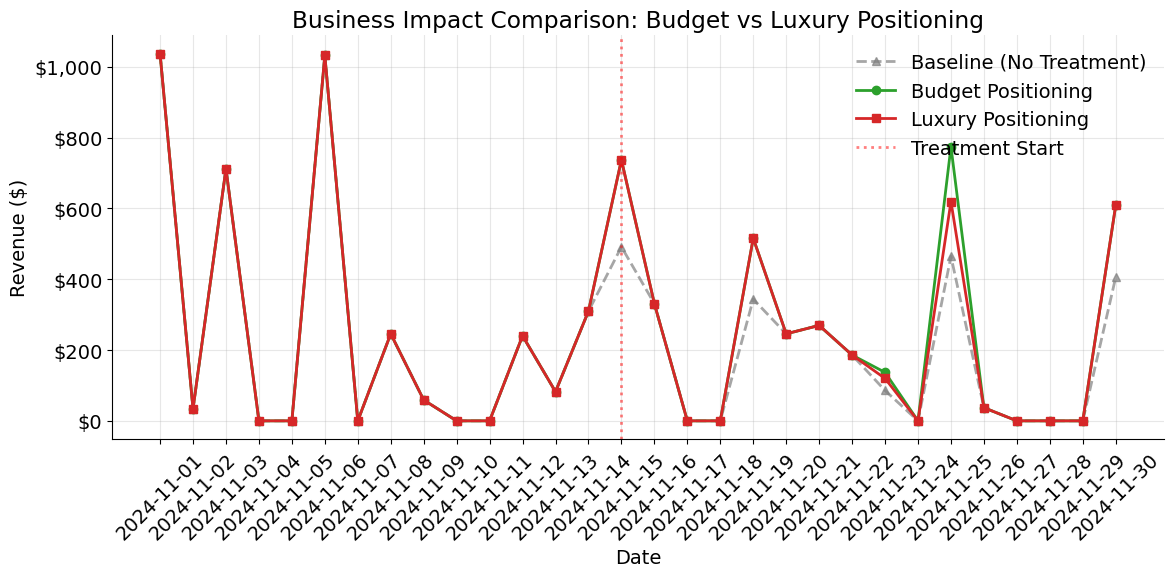


BUSINESS IMPACT COMPARISON

Baseline (No Treatment):
  Pre-Treatment Revenue:  $26.80
  Post-Treatment Revenue: $17.88
  Change: -33.3% (should be ~0%)

Budget Positioning:
  Pre-Treatment Revenue:  $26.80
  Post-Treatment Revenue: $24.01
  Lift: -10.4%

Luxury Positioning:
  Pre-Treatment Revenue:  $26.80
  Post-Treatment Revenue: $22.94
  Lift: -14.4%

Winner: Budget Positioning (+-10.4%)


In [14]:
# Compare positioning strategies
stats = plot_positioning_comparison(metrics, enriched_results["enriched"], luxury_results["enriched"], "2024-11-15")

# Print comparison results
print_positioning_comparison(stats)

In this simplified demonstration, we've shown how different prompts generate different content and drive different business outcomes. This illustrates the **Learn · Decide · Repeat** loop as the foundation of self-learning AI systems at scale.

## Limitations and Caveats

This demonstration uses a simplified, toy version of a self-learning content generation system. Several important limitations should be considered:

- **Simulated treatment effects**: The business impact shown here is injected via configuration, not measured from actual shopper behavior. In production, treatment effects must be estimated through proper experimentation.
- **Small sample size**: We demonstrate with only a few products. Real systems process millions of products, requiring robust infrastructure and careful attention to statistical power.
- **Known ground truth**: The simulator provides known effect sizes for validation. In practice, true causal effects are never directly observable and must be inferred through careful experimental design.
- **No guardrails shown**: Production systems require automated quality filters to prevent low-quality or harmful content from reaching customers. This notebook focuses on the measurement loop, not the filtering layer.
- **Local LLM limitations**: The `llama3.2` model used here is smaller and less capable than production-grade models. Content quality varies significantly across model sizes and architectures.